# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 4 minutes

This notebook calculates the concordance between differential gene expression and the causal relationships between their protein products. This analysis assumes the forward hypothesis, under which gene expression is believed to be correlated with protein activity. While there are many faults to this assumption, it directly enables a very simple analysis of a knowledge assembly. 

### Notebook Imports

In [1]:
import logging
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from matplotlib_venn import venn2
import seaborn as sns

import pybel
import pybel_tools as pbt
from pybel_tools.analysis.concordance import *
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
from pybel_tools.visualization import to_jupyter

In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Notebook Provenance

The time of execution, random number generator seed, and the versions of the software packages used are displayed explicitly.

In [3]:
time.asctime()

'Sun Aug 27 11:39:19 2017'

In [4]:
# seed the random number generator
import random
random.seed(127)

In [5]:
pybel.__version__

'0.7.3-dev'

In [6]:
pbt.__version__

'0.2.2-dev'

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [7]:
bms_base = os.environ['BMS_BASE']

#### OwnCloud

The differential gene expression data used in this notebook is currently not published, and is obfuscated with reference through our team's internal data storage system with [OwnCloud](https://owncloud.org/).

In [8]:
owncloud_base = os.environ['OWNCLOUD_BASE']

# Data

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [9]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers', 'alzheimers.gpickle')

In [10]:
graph = pybel.from_pickle(pickle_path)

In [11]:
graph.version

'4.0.3'

All orthologies are discarded before analysis.

In [12]:
pbt.filters.remove_nodes_by_namespace(graph, {'MGI', 'RGD'})

Following the forward hypothesis, the knowledge graph is collapsed to genes using  [pbt.mutation.collapse_by_central_dogma_to_genes](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.collapse_by_central_dogma_to_genes).

In [13]:
pbt.mutation.collapse_by_central_dogma_to_genes(graph)

An additional assumption is made about the activities of variants of proteins and genes. All variants are collapsed to the reference gene.

In [14]:
pbt.mutation.rewire_variants_to_genes(graph)

In [15]:
pbt.summary.print_summary(graph)

Nodes: 3701
Edges: 19562
Citations: 1760
Authors: 9305
Network density: 0.0014285401315933604
Components: 70
Average degree: 5.2855984868954335
Compilation warnings: 2578


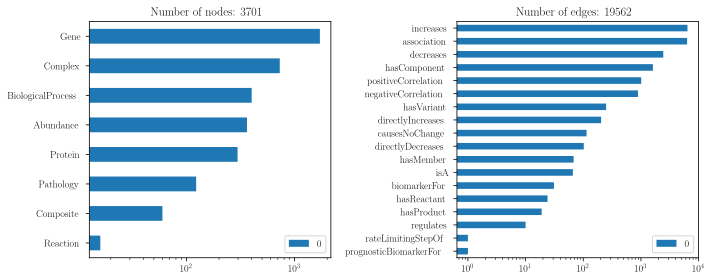

In [16]:
pbt.summary.plot_summary(graph, plt, figsize=(10, 4))
plt.show()

## Differential Gene Expression

Differential gene expression data can be obtained from many sources, including ADNI and other large clinical studies. This analysis is concerned with the log-fold-changes on each gene, and not necessarily the p-value. This is better as a data-driven process becuase it does not require a model or multiple hypothesis testing on raw data.

In [17]:
data_path = os.path.join(owncloud_base, 'alzheimers', 'SevAD.csv')
target_columns = ['Gene.symbol', 'logFC']

In [18]:
df = pd.read_csv(data_path)
df = df.loc[df['Gene.symbol'].notnull(), target_columns]
df.head()

,Gene.symbol,logFC
0,ZNF616,-4.244691
1,DEFB125,3.974393
3,SNAP23,3.337636
4,PHLDB2,3.192559
5,LOC389895,-4.296850


A histogram of the log-fold-changes shows that the data are normally distributed, as expecOn the left, the number of shared elements in the knowledge assembly and differential gene data set are counted.

On the right, a histogram of the log-fold-changes shows that the data are normally distributed, as expected for differential gene expression data.ted for differential gene expression data.

In [19]:
data = {k: v for _, k, v in df.itertuples()}

In [20]:
hgnc_names = pbt.summary.get_names_by_namespace(graph, 'HGNC')
df_names = set(df['Gene.symbol'])
overlapping_hgnc_names = hgnc_names & df_names

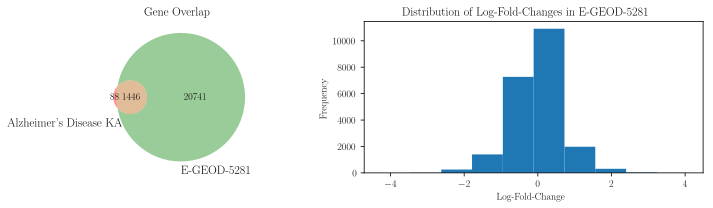

In [21]:
fix, (rax, lax) = plt.subplots(1, 2, figsize=(10, 3))

lax.set_title('Distribution of Log-Fold-Changes in E-GEOD-5281')
lax.set_xlabel('Log-Fold-Change')
lax.set_ylabel('Frequency')
lax.hist(list(data.values()))

rax.set_title('Gene Overlap')
venn2([hgnc_names, df_names], set_labels=["Alzheimer's Disease KA", 'E-GEOD-5281'], ax=rax)
plt.tight_layout()
plt.show()

# Analysis

## Data Integration

Finally, the differential gene expression data are ovelayed on the BEL graph with [pbt.integration.overlay_type_data](http://pybel-tools.readthedocs.io/en/latest/integration.html#pybel_tools.integration.overlay_type_data)

In [22]:
key = 'weight'
cutoff = 0.3

In [23]:
pbt.integration.overlay_type_data(graph, data, key, GENE, 'HGNC', overwrite=False, impute=0)

In [24]:
graph.edge[graph.nodes()[25]].keys()

dict_keys([('Pathology', 'DO', "Alzheimer's disease"), ('Gene', 'dbSNP', 'rs3757536')])

## Concordance

The effect of the cutoff is explored when calculating the concordance of the full knowledge assembly.

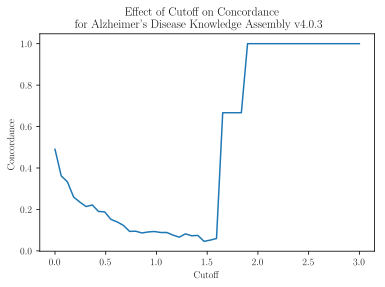

In [25]:
cutoffs = np.linspace(0, 3, 50)

plt.plot(cutoffs, [
    calculate_concordance(graph, key, cutoff=cutoff)
    for cutoff in cutoffs
])

plt.title('Effect of Cutoff on Concordance \nfor {}'.format(graph))
plt.ylabel('Concordance')
plt.xlabel('Cutoff')
plt.show()

### Stratify by Subgraph

The distribution of the concordance values across the stratified subgraphs is displayed below.

In [26]:
concordance_df = pd.DataFrame.from_dict(
    {
        value.replace(' subgraph', ''): calculate_concordance_helper(subgraph, key, cutoff)
        for value, subgraph in pbt.selection.get_subgraphs_by_annotation(graph, 'Subgraph').items()
    }, 
    orient='index'
)

concordance_df.columns = 'Correct', 'Incorrect', 'Ambiguous', 'Unassigned'

 subgraphs that contain at least one correct or one incorrect relation are shown.

In [27]:
has_correct = concordance_df['Correct'] > 0
has_incorrect = concordance_df['Incorrect'] > 0

concordance_df[has_correct | has_incorrect].sort_values('Correct', ascending=False).head(20)

,Correct,Incorrect,Ambiguous,Unassigned
Interleukin signaling,20,41,25,285
Tumor necrosis factor,20,29,16,214
miRNA,10,16,80,167
Insulin signal transduction,10,19,17,761
Nuclear factor Kappa beta,8,29,19,60
Inflammatory response,8,17,23,488
Chemokine signaling,6,12,4,168
Neurotrophic,6,7,1,56
Nerve growth factor,6,10,5,171
Caspase,5,18,15,156


The 20 highest concording subgraphs are shown. Even without statistical analysis, these data suggest that high concorance values are most likely due to random chance.

In [28]:
concordance_df['Concordance'] = concordance_df['Correct'] / (concordance_df['Correct'] + concordance_df['Incorrect'])

In [29]:
concordance_df.sort_values('Concordance', ascending=False).head(20)

,Correct,Incorrect,Ambiguous,Unassigned,Concordance
Plasminogen activator,1,0,2,97,1.000000
Metabolism of steroid hormones,2,0,0,6,1.000000
Cell cycle,1,0,7,83,1.000000
Vitamin,2,0,0,41,1.000000
Albumin,3,1,0,26,0.750000
Reactive oxygen species,2,1,4,184,0.666667
Interferon signaling,2,1,2,75,0.666667
Complement system,3,3,3,97,0.500000
Notch signaling,2,2,8,117,0.500000
DKK1,5,5,8,77,0.500000


While these calculations were presented in a dataframe, they can be directly acquired with `calculate_concordance_by_annotation`.

In [30]:
%%time
results = calculate_concordance_by_annotation(graph, 'Subgraph', key, cutoff)

CPU times: user 427 ms, sys: 30.1 ms, total: 458 ms
Wall time: 466 ms


The distribution of concordance values over all subgraphs is shown.

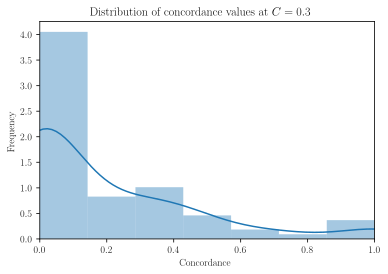

In [31]:
sns.distplot([
    result
    for result in results.values() 
    if result != -1
])

plt.title('Distribution of concordance values at $C={}$'.format(cutoff))
plt.xlabel('Concordance')
plt.ylabel('Frequency')
plt.xlim([0, 1])
plt.show()

## Conclusions

Varying the threshold from just zero to just above zero to much more stringent reveals varying results. High-dimensional data visualization techniques will need to be used to identify the effect of the threshold, and eventually the stability of concordance values through randomized permutation tests to assess the reliability of this method.

Without further methodological development, this method seems unlikely to make useful assistance in analysis.